# NAML Project 4

## Credit Card Fraud Detection 

In [ ]:
dataset = pd.read_csv('creditcard.csv')

## Data Normalization

The goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values.

We apply this technique to all the columns of the dataset except for `Class`

In [ ]:
# remove 'Class' column
dataset_to_be_normalized = dataset.iloc[:,:-1]

# compute the mean 
data_mean = dataset_to_be_normalized.mean()
# compute the standard deviation
data_std = dataset_to_be_normalized.std()
# normalize the data
data_normalized = (dataset_to_be_normalized - data_mean) / data_std

# append 'Class' column
data_normalized['Class'] = dataset.iloc[:,-1]

Display the distribution of the new values

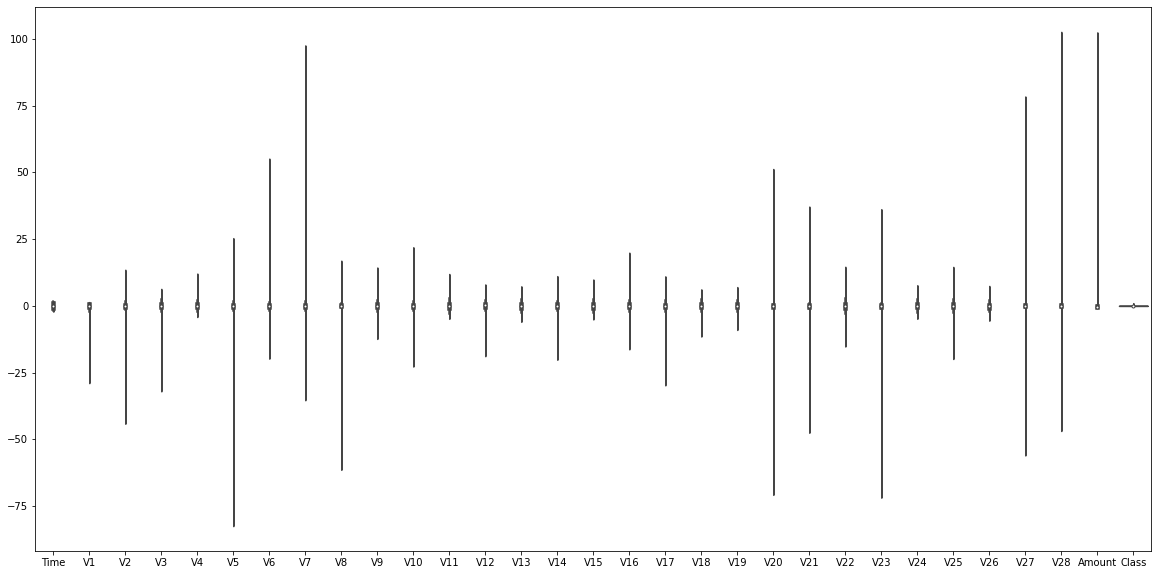

In [ ]:
_, ax = plt.subplots(figsize=(20,10))
sns.violinplot(data = data_normalized, ax = ax)

## Dataset division - Train-validation split

Shuffle the data using the np.random.shuffle function and split the data as follows:

- put 70% in the training dataset
- put 30% in the validation dataset

In [ ]:
# define parameter : test_set / training_set
fraction_validation = 0.3 # 30% of test set and 70% of training set

# parse to numpy
data_normalized_np = data_normalized.to_numpy()

# shuffle data
np.random.seed(0) # set seed to 0 for reproducibility
np.random.shuffle(data_normalized_np) 

# divide into training_set and test_set
num_train = int(data_normalized_np.shape[0] * (1 - fraction_validation))

train_set = data_normalized_np[:num_train,:]
valid_set = data_normalized_np[num_train:,:]

print('train set size     : %d' % train_set.shape[0])
print('validation set size: %d' % valid_set.shape[0])

train set size     : 199364
validation set size: 85443


Visualize the dimensions of the sets 

In [ ]:
print('Dataset: ')
print('Number of fraud transactions     : %d' % sum(dataset["Class"]))
print('Number of non-fraud transactions : %d' % sum(dataset["Class"] == 0))
print('Number of transactions           : %d' % dataset["Class"].shape[0])

print('\nTraining set: ')
print('Number of fraud transactions     : %d' % np.sum(train_set[:,data_normalized_np.shape[1]-1]))
print('Number of non-fraud transactions : %d' % np.sum(train_set[:,data_normalized_np.shape[1]-1]  == 0))
print('Number of transactions           : %d' % train_set.shape[0])

print('\nValidation set: ')
print('Number of fraud transactions     : %d' % np.sum(valid_set[:,data_normalized_np.shape[1]-1]))
print('Number of non-fraud transactions : %d' % np.sum(valid_set[:,data_normalized_np.shape[1]-1] == 0))
print('Number of transactions           : %d' % valid_set.shape[0])

Dataset: 
Number of fraud transactions     : 492
Number of non-fraud transactions : 284315
Number of transactions           : 284807

Training set: 
Number of fraud transactions     : 337
Number of non-fraud transactions : 199027
Number of transactions           : 199364

Validation set: 
Number of fraud transactions     : 155
Number of non-fraud transactions : 85288
Number of transactions           : 85443


## Preprocess data - Random under sampling

The two main approaches to randomly resampling an imbalanced dataset are to delete examples from the majority class, called undersampling, and to duplicate examples from the minority class, called oversampling.


*   Random oversampling duplicates examples from the minority class in the training dataset and can result in overfitting for some models.
*   Random undersampling deletes examples from the majority class and can result in losing information invaluable to a model.

Random oversampling involves randomly selecting examples from the minority class, with replacement, and adding them to the training dataset. Random undersampling involves randomly selecting examples from the majority class and deleting them from the training dataset.

*This method is valid under the hypothesis that the number of the no-fraud transaction is more than a hundred times the number of fraud ones*


In [ ]:
# this function is used to create the training and test sets for the ANN

def RUS_array(ratio,train_set):
  '''It returns an array obtained by merging two arrays, one containing the fraud training set and the
  other containing the non-fraud training set.
  The ratio parameter defines the ratio fraud/non-fraud.
  e.g.: ratio=1 and len(train_fraud)= 100 implies that len(new_train_not_fraud)=100.
  
  @param: ratio It is the ratio between fraud and non-fraud data; it is defined as: ratio:=fraud_set/non-fraud_set.
  @param train_set It is the training set.
  '''
  fraud = train_set[train_set[:,-1] == 1]
  non_fraud = train_set[train_set[:,-1] == 0]

  np.random.seed(0) # set seed to 0 for reproducibility
  np.random.shuffle(non_fraud) 

  new_non_fraud = non_fraud[:int(fraud.shape[0]*ratio),:]

  new_train_set = np.r_[new_non_fraud,fraud]
  np.random.shuffle(new_train_set) 

  # concatenate the two matrix
  return new_train_set

In [ ]:
def RUS(ratio, training_set):
  '''It returns a list obtained by merging two lists, one containing the fraud training set and the
  other containing the non-fraud training set.
  The ratio parameter defines the ratio fraud/non-fraud.
  e.g.: ratio=1 and len(train_fraud)= 100 implies that len(new_train_not_fraud)=100.
  
  @param: ratio It is the ratio between fraud and non-fraud data; it is defined as: ratio:=fraud_set/non-fraud_set.
  @param training_set It is the training set.
  '''
  # initialize the two lists
  train_fraud = list()
  train_not_fraud = list()

  # for each sample in the training set, append it to the proper class
  for sample in training_set:
    if sample[-1] == 1:
      train_fraud.append(sample)
    else:
      train_not_fraud.append(sample)
  
  print('train_fraud len        : ', len(train_fraud))
  print('train_not_fraud len    : ', len(train_not_fraud))
  
  # compute new length of train_not_fraud
  new_length_train_not_fraud = int(len(train_fraud) / ratio)
  print('new train_not_fraud len: ', new_length_train_not_fraud)

  # shuffle train_not_fraud
  np.random.seed(0) # set seed to 0 for reproducibility
  np.random.shuffle(train_not_fraud)

  # take the first new_length_train_not_fraud elements from train_not_fraud
  train_not_fraud_reduced = train_not_fraud[0:new_length_train_not_fraud]

  # create a unique list for the training set
  train_fraud.extend(train_not_fraud_reduced)

  # shuffle the result set
  np.random.seed(0) # set seed to 0 for reproducibility
  np.random.shuffle(train_fraud)

  print('new training set len   : ', len(train_fraud))
  print('\n')

  # return the whole new training set
  return train_fraud

In [ ]:
# define parameters -> inside the training_set: fraud / non-fraud
ratio1 = 1 # 50:50
ratio2 = 34/66 # 34:66
ratio3 = 1/3 # 25:75

Apply random under sampling to the training set --> obtain lists 

In [ ]:
training_set1 = RUS(ratio1, train_set)
training_set2 = RUS(ratio2, train_set)
training_set3 = RUS(ratio3, train_set)

train_fraud len        :  337
train_not_fraud len    :  199027
new train_not_fraud len:  337
new training set len   :  674


train_fraud len        :  337
train_not_fraud len    :  199027
new train_not_fraud len:  654
new training set len   :  991


train_fraud len        :  337
train_not_fraud len    :  199027
new train_not_fraud len:  1011
new training set len   :  1348




Apply RUD and obtain arrays 

In [ ]:
# necessary below for the ANN
train_set1 = RUS_array(ratio1,train_set)
train_set2 = RUS_array(ratio2,train_set)
train_set3 = RUS_array(ratio3,train_set)

## **Classification techniques** - Logistic Regression



### Define functions 

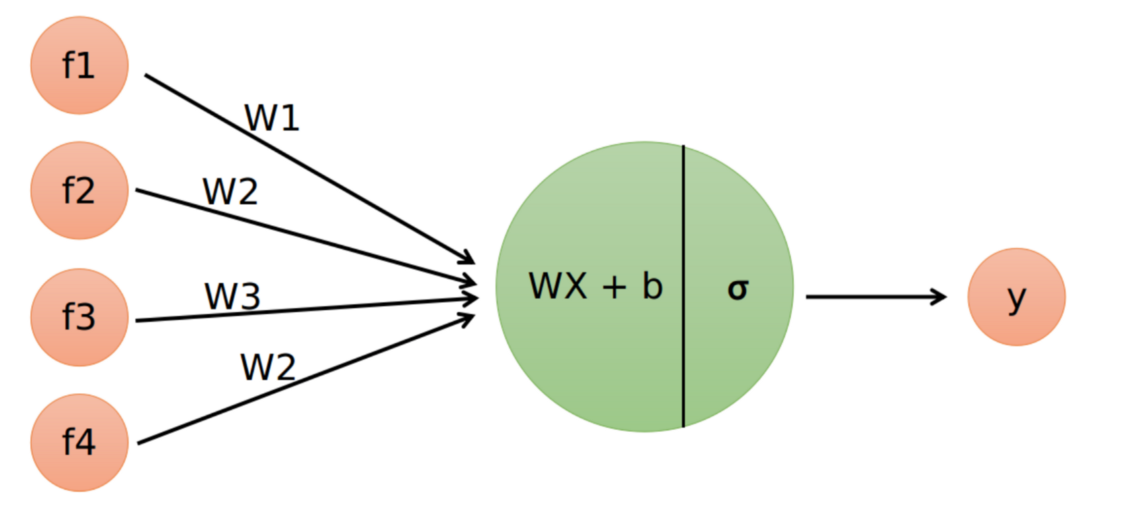

Firstly we define some useful functions

In [ ]:
def initialize_params(weight_size):
  """
  The purpose of this function is to initialize the weights 

  @params: weight_size: number of features 
  @return: array of dimention 'weights_size' initialize to a random number between 0 and 1
  """
  
  rgen = np.random.RandomState(seed = 1) # generator of random numbers, seed = 1 for reproducibility
  # loc = mean (center) of the distribution  
  # scale = standard deviation 
  # size = output shape
  return rgen.normal(loc=0.0, scale=0.1, size=weight_size ) 
  #return np.zeros(weight_size)

**Sigmoid function**, also called logistic sigmoid function, has the role of activation function.  It is define as 



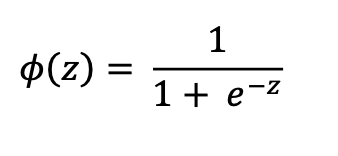

where z is 

> *z = w * x + b*

and

> *w = weights*

> *x = features*

> *b = bias*


The output of the sigmoid function is interpreted as the probability of
a particular example belonging to class 1.

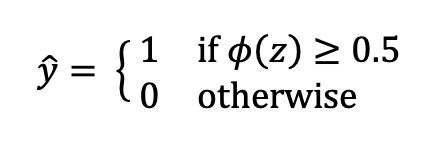

In [ ]:
def sigmoid(z):
  """
  This function returns the value of the sigmoid function given an input value

  @params: z: a linear combination of the input and the features associated with the training examples
  @return: value of the sigmoid in the specified point
  """
  return (1/(1+np.exp(-z)))

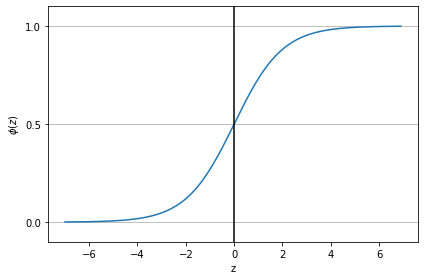

In [ ]:
# print the sigmoid function in the range (-7 , +7)

# define range
z = np.arange(-7, 7, 0.1) 

# calculate the sigmoid
phi_z = sigmoid(z) 
plt.plot(z, phi_z)

plt.axvline(0.0, color='k') 
plt.ylim(-0.1, 1.1)

# add labels 
plt.xlabel('z')
plt.ylabel('$\phi (z)$')

# add y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca() # get current axis
ax.yaxis.grid(True) # display axis 
plt.tight_layout() # adjust the padding between and around subplots

**Loss** can be defined as the error that is present between the actual output and the predicted output. We want the value of the loss function to be as low as possible as it would reduce the loss and the predicted value would be close to the actual value. We will use the following loss function

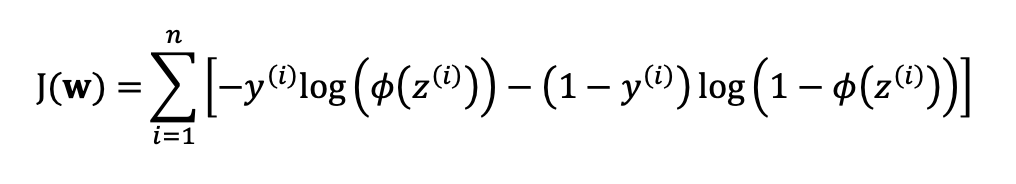

In [ ]:
def loss(x,y,params,bias):
  """
  This function computes the loss described above. The only difference is that 
  the funtion will compute the mean instad of a simple sum 

  @params: x: features 
  @params: y: outputs
  @params: params: weights
  @params: bias: bias
  @return: value of the loss 
  """
  return -np.sum(np.log( y * np.clip(sigmoid(np.dot(x, params) + bias) ,1e-15,1-1e-15) 
                  + (1-y) * np.clip(1-sigmoid(np.dot(x, params) + bias),1e-15,1-1e-15))) 

The following plot shows the sigmoid activation on the x-axis in the range 0 to 1 (the inputs to the sigmoid function were z values in the range –10 to 10) and the associated logistic cost on the y-axis

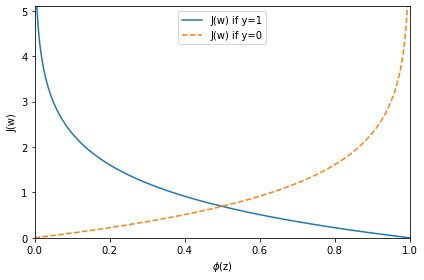

In [ ]:
# print log function 
def cost_1(z):
  return - np.log(sigmoid(z))

def cost_0(z):
  return - np.log(1 - sigmoid(z))

# define the range
z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)

c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')

c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')

# impose the limits 
plt.ylim(0.0, 5.1)
plt.xlim([0, 1])

# add the axis legend
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')

# add legend
plt.legend(loc='best') 
plt.tight_layout() 

To fit the model is used gradient descent method 

In [ ]:
def fit(x,y):
  """
  It will fit the model using gradient descent method
  
  @params: x: training set features 
  @params: y: training set outputs 
  @return: weights and bias after training
  """

  # hyperparameters

  num_epochs = 500
  learning_rate_min = 5e-5
  learning_rate_max = 2e-4
  learning_rate_decay = 2000

  batch_size = 100
  num_train = x.shape[0]

  # setup
  params = initialize_params(x.shape[1])
  gradients = list()
  bias = 0

  train_history = [loss(x, y, params,bias)]

  # training loop
  t0 = time.time()
  for epoch in tqdm(range(num_epochs)):

    minibatch = np.random.choice(num_train, batch_size)
    x_mini = x[minibatch,:]
    y_mini = y[minibatch]

    # evaluete the gradients
    value = np.dot(x_mini, params) + bias
    y_pred = sigmoid(value)
    gradients =  np.dot(x_mini.T, (y_pred - y_mini))
    bias_gradients = np.sum(y_pred - y_mini)

    # evaluate the learning_rate
    learning_rate = max(learning_rate_min, learning_rate_max * (1 - epoch/learning_rate_decay))
    for i in range(len(params)):

      # update the parameters
      params[i] -= learning_rate * gradients[i]
      
    bias -= learning_rate * bias_gradients
    train_history.append(loss(x, y, params,bias))

  print('train loss: %1.3e' % train_history[-1])
  plt.loglog(train_history, label = 'train loss')

  return [params,bias]

In [ ]:
def prediction(x,params):
  """
  It will return predicted values casted to 0 and 1

  @params: x: features 
  @params: params: [weights, bias]
  """
  w = params[0]
  bias = params[1]

  # evaluate the sigmoid
  z = np.dot(x, w) + bias
  phi = sigmoid(z)
  
  pred = list()
  
  # cast the outputs predicted
  y = valid_set[:,-1]
  for i in range(phi.shape[0]):
    pred.append(1 if phi[i] >= 0.9 else 0)
                
  return pred 

In [ ]:
def logistic_regression(train_set,valid_set):
  """
  Algorithm 
  """
  
  train_set = np.array(train_set)
  valid_set = np.array(valid_set)
  x = train_set[:,:-1]
  y = train_set[:,-1]

  # fit
  params = fit(x,y)

  # test
  x_valid = valid_set[:,:-1]
  pred = prediction(x_valid,params)

  return pred

### Apply the algorithm




  0%|          | 0/500 [00:00<?, ?it/s]

train loss: 1.383e+02


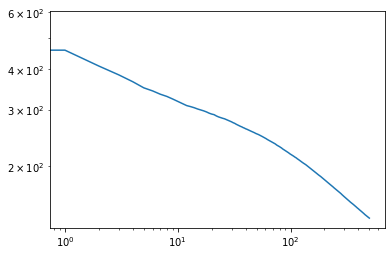

In [ ]:
predictionsLR1 = logistic_regression(training_set1,valid_set)

  0%|          | 0/500 [00:00<?, ?it/s]

train loss: 2.031e+02


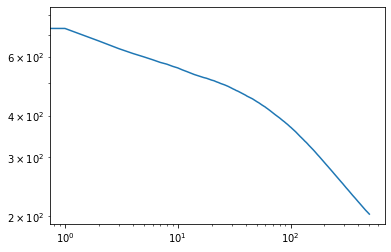

In [ ]:
predictionsLR2 = logistic_regression(training_set2,valid_set)

  0%|          | 0/500 [00:00<?, ?it/s]

train loss: 2.607e+02


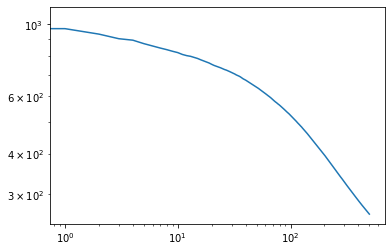

In [ ]:
predictionsLR3 = logistic_regression(training_set3,valid_set)